# P1: Solve the OpenAI Gym [Taxi V3](https://gym.openai.com/envs/Taxi-v3/) Environment
---

## Introduction
[OpenAI Gym](https://gym.openai.com/docs/) is a framework that provides RL environments of varying complexity with the same standard API making it easy to develop and benchmark RL algorithms. The [Taxi-V3](https://gym.openai.com/envs/Taxi-v3/) environmnet present a simple, text environment where actions and state (observations) are both discrete. 

In [1]:
import gym

The `gym.make()` API can be used to spawn any of the available environments by passing its full name.

In [2]:
taxi = gym.make('Taxi-v3')

The Taxi environment has 500 states and 6 possible actions.

In [3]:
taxi.action_space

Discrete(6)

In [4]:
taxi.observation_space

Discrete(500)

The task and reward structure are described in the [documentation](https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/taxi.py#L25)

In [5]:
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Submission
- Submit your solution as a Jupyter notebook. 
- Ensure that all cells in the notebook have been executed and the output is showing
- Ensure that your solution consistently reaches the average cumulative reward defined in the rubric (link below)
- Post your solution on Github and share the link to your commit as a direct message in Slack

## Evaluation
The goal of the project is to get a certain average (cumulative) reward over 100 episodes. To pass the project, you must meet all the requirments in the project [rubric](https://github.com/KnowchowHQ/rl-in-action/blob/master/C1-RL-Intro/W3OH/P1-rubric.md) 

## Requirements
You must meet each of the requirements below to pass the project. The solution has to be submitted as a Jupyter nnotebook.
1. Describe the methods and variables in the class DiscreteEnv which is the parent class of the Taxi V3 class.
2. Describe the methods and variables in the Taxi V3 class.
3. Describe the Taxi V3 environment, its actions, states, reward structure and the rationale behind such a reward structure.
4. Train an algorithm to achieve a 100-episode average reward with a 5th percentile of 7.2 or higher and a 95th percentile of 8.2 or higher on the last 1000 episodes.
5. The algorithm should be able to perform pick-ups and dropoffs with zero penalties over 1000 episodes.
6. Document your solution including all hyper parameters and how those hyperparameters were selected.


# Solution
## Methods and variables - DiscreteEnv
The parent class **DiscreteEnv**, as shown in [discrete.py](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) has the methods and variables.

**Methods**
- Seed
- Reset
- Step

**Variables**
- nS: number of states
- nA: number of actions
- P: transitions
- isd: initial state distribution

## Methods and variables - TaxiV3
The class **Taxi-v3**, as shown in [discrete.py](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) has the methods and variables.

**Variables**
- Passenger locations:
 - 0: R(ed)
 - 1: G(reen)
 - 2: Y(ellow)
 - 3: B(lue)
 - 4: in taxi
- Destinations:
 - 0: R(ed)
 - 1: G(reen)
 - 2: Y(ellow)
 - 3: B(lue)
    Actions:
- There are 6 discrete deterministic actions:
 - 0: move south
 - 1: move north
 - 2: move east
 - 3: move west
 - 4: pickup passenger
 - 5: drop off passenger

**Methods**
- Render
- Encode
- Decode

## Taxi algorithm description

There are **4 locations** (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive **+20 points for a successful dropoff**, and **lose 1 point for every timestep** it takes. There is also a **10 point penalty** for illegal pick-up and drop-off actions.

Total number of states is 500. 
- 25 location of the taxi x 5 (passenger location) x 4 (destinations)


## Agent
The solution to the problem is using the object Agent which interacts with the environment. In the current implementation SARSA algorithm developed. 
The available hyperparameters are **alpha**,  **gamma** and **epsilon** and can be set by the user. 

In [20]:
import numpy as np
from collections import defaultdict, deque
import sys
import math
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, env, policy='Sarsa', alpha=0.1, gamma=0.9, epsilon=0.9999):
        '''
        Initialize agent.
        Params
        ======
        - nA: number of actions available to the agent
        - Q : state value function (it will grow at the end to a nS entries but nS does not need to be defined explicitly)
        - gamma: the discount factor in SARSA algorithm
        - alpha: learning rate in SARSA algorithm
        - epsilon: parameter for the epsilon greedy policy
        - complete: indicates when all criteria are met and exits the training
        - epsilon_init: initial epsilon value for statistical purposes
        '''
        self.env = env
        self.nA = env.nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.complete = False
        self.epsilon_init = epsilon

    def epsilon_greedy_probs(self, Q_s):
        '''
        Obtains the action probabilities corresponding to epsilon-greedy policy
        ''' 
        self.epsilon = self.epsilon**2
        # epsilon = (1/self.count)**0.6
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        policy_s[np.argmax(Q_s)] = 1 - self.epsilon + (self.epsilon / self.nA)
        return policy_s    
    
    def select_action(self, state):
        '''
        Given the state, select an action.
        Params
        ======
        - state: the current state of the environment
        Returns
        =======
        - action: an integer, compatible with the task's action space
        '''
        self.policy_s = self.epsilon_greedy_probs(self.Q[state])
        return np.random.choice(np.arange(self.nA), p=self.policy_s)

    def step(self, state, action, reward, next_state, done):
        '''
        Update the agent's knowledge, using the most recently sampled tuple.
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        '''
        # Implementation of SARSA max
        # self.Q[state][action] = self.Q[state][action] + self.alpha*(reward + \
        # self.gamma * max(self.Q[next_state]) - self.Q[state][action])

        # Implementation of SARSA
        self.Q[state][action] = self.Q[state][action] + self.alpha*(reward + \
               self.gamma * np.dot(self.policy_s,self.Q[next_state]) - self.Q[state][action])
        
        # next_action = np.random.choice(np.arange(self.nA), p=self.policy_s)
        # self.Q[state][action] = self.Q[state][action] + self.alpha*(reward + \
        # self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
        
    def interact(self, num_episodes=20000):
        '''
        Monitor agent's performance.
        
        Params
        ======
        - env: instance of OpenAI Gym's Taxi-v3 environment
        - agent: instance of class Agent (see Agent.py for details)
        - num_episodes: maximum number of episodes of agent-environment interaction
        '''
        self.window_rewards = deque(maxlen=100) #episode rewards of last 100 episodes
        self.avg_episode_rewards = [] # last 100-episode episode average rewards over episodes
        self.percentile95 = [] # last 1000 episode 100-episode average percentile 95 across episodes
        self.percentile5 = []
        self.penalties = []
        self.i_episode_final = 0
        # for each episode
        for i_episode in range(1, num_episodes+1):
            # begin the episode
            state = self.env.reset()
            # initialize the sampled reward
            episode_reward = 0
            episode_penalty = 0
            while True:
                # agent selects an action
                action = self.select_action(state)
                # agent performs the selected action
                next_state, reward, done, _ = self.env.step(action)
                # agent performs internal updates based on sampled experience
                self.step(state, action, reward, next_state, done)
                # update the sampled reward
                episode_reward += reward
                # update the state (s <- s') to next time step
                state = next_state
                if reward == -10:
                     episode_penalty += 1 
                if done:
                    # save episode reward
                    self.window_rewards.append(episode_reward)
                    self.penalties.append(episode_penalty)
                    if i_episode >= 100:
                        self.avg_episode_rewards.append(np.mean(self.window_rewards)) # for statistics
                    if i_episode >=1100:
                        self.percentile95.append(np.percentile(self.avg_episode_rewards[-1000:], 95))
                        self.percentile5.append(np.percentile(self.avg_episode_rewards[-1000:], 5))
                        self.check_complete()
                    break
            if self.complete:
                print(f'\nTraining is complete after {i_episode} episodes\n')
                self.i_episode_final = i_episode
                break
            # Monitor progress 
            if (i_episode % 100 == 0):
                print('\r', f'Episode: {i_episode}, Reward = {np.mean(self.window_rewards)}', end='')
                sys.stdout.flush()
            
        if i_episode >= num_episodes:
            self.i_episode_final = i_episode
            print(f'\nThe training did not achieve the specs after {num_episodes} episodes.\n')
        self.summary()
                

    def check_complete(self, limit_percentile5=7.2, limit_percentile95=8.2):
        '''
        Checks whether the requirements are met. Specs are:
        - c5: The 5th percentile of the last 1000 episodes 100-episode average rewards is greater to the lowest limit
        - c95: The 5th percentile of the last 1000 episodes 100-episode average rewards is greater to the lowest limit
        - there are no penalties in the last 1000-episodes
        '''
        c5 = (self.percentile5[-1] > limit_percentile5)
        c95 = (self.percentile95[-1] > limit_percentile95)
        self.complete =  c5 and c95 and (np.sum(self.penalties[-1000:]) == 0)
    
    def summary(self):
        '''
        Plots statistics of the results
        '''
        fig, ax = plt.subplots(figsize = (12,7))
        limit_percentile5 = 7.2
        limit_percentile95 = 8.2
        ax.axhline(y=limit_percentile5, color="red", linestyle="--", )
        ax.axhline(y=limit_percentile95, color="green", linestyle="--")
        xmax = self.i_episode_final - self.i_episode_final %2500 + 2500 
        ax.set( ylabel='Rewards\nPenalties', xlabel='Episode #', title='Statistics', ylim=[0,10], xlim=[1,xmax])
        ax.grid()
        ax.plot(np.arange(100, self.i_episode_final+1), self.avg_episode_rewards, linewidth=0.25)
        ax.plot(np.arange(1100, self.i_episode_final+1), self.percentile95, color='green', linewidth=2)
        ax.plot(np.arange(1100, self.i_episode_final+1), self.percentile5, color='red', linewidth=2)
        ax.plot(np.arange(self.i_episode_final), self.penalties, color='magenta', linewidth=0.25)
        ax.legend(['Lower 5% percentile limit', 'Lower 95% perecentile limit',
                   '100-episode Avg Reward', '95% last 1000-episode Avg Reward percentile',
                   '5% last 1000-episode Avg Reward percentile', 'Current episode penatly count'],
                  loc='center right')
        txt_plot = f'alpha   = {self.alpha}\ngamma = {self.gamma} \nepsilon = {self.epsilon_init}\nTotal Episodes = {self.i_episode_final}' 
        ax.text(2500, 8.5 ,txt_plot, fontsize = 12)

## Training
Train the agent, training will stop once the criteria are met. I am using three different cases. It seems that lowering alpha is not beneficial and does not reach performance in 20000 episodes.

Increasing gamma from 0.9 to 0.95 improved the performance. A larger set of combinations is necessary to optimize the performance. 

 Episode: 15300, Reward = 7.658
Training is complete after 15378 episodes



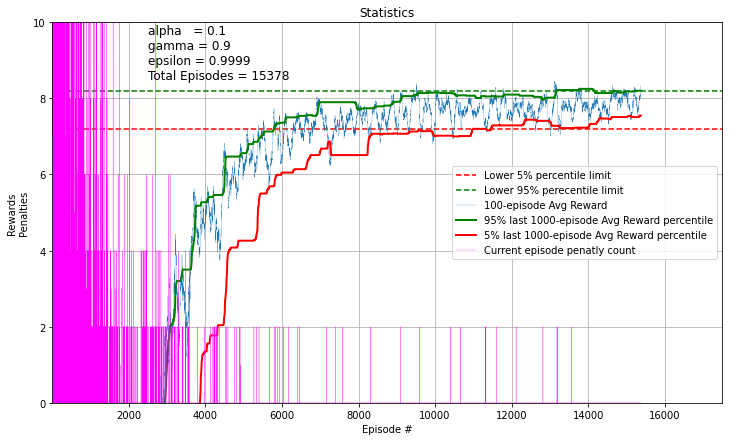

In [21]:
agent = Agent(taxi)
agent.interact()

 Episode: 20000, Reward = 7.5933
The training did not achieve the specs after 20000 episodes.



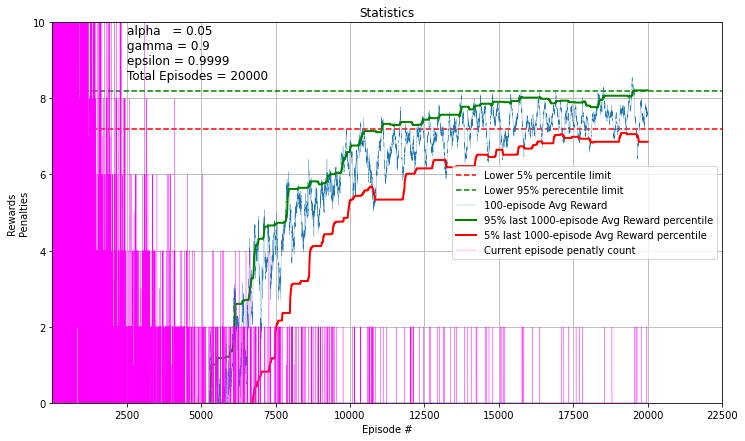

In [18]:
agent = Agent(taxi, alpha=0.05)
agent.interact()

 Episode: 12900, Reward = 7.687
Training is complete after 12902 episodes



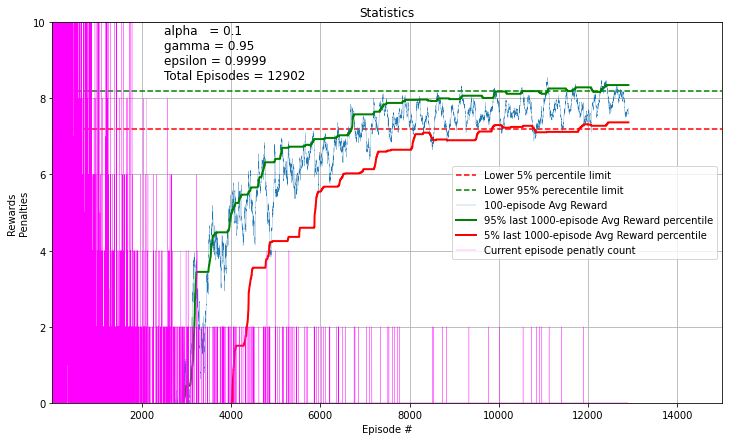

In [19]:
agent = Agent(taxi, gamma=0.95)
agent.interact()